In [1]:
from iqvis import plotting_backend as pb
from iqvis import data_objects as do
from iqvis import event_calculation as ec
import numpy as np
import pandas as pd
import os

In [2]:
from obspy.core import UTCDateTime
from obspy.core.inventory import inventory
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial import distance

"""
CHUNK SET-UP
"""
t1 = UTCDateTime(2018,1,8)
t2 = UTCDateTime(2018,1,9)


c_path = '/Users/jaredmagyar/Documents/SorsdalData/catalogues/bbs'
stat_path = '/Users/jaredmagyar/Documents/SorsdalData/stations/sorsdal_stations.xml'
w_path = '/Users/jaredmagyar/Documents/SorsdalData/processed'
ref_path = '/Users/jaredmagyar/Documents/SorsdalData/unprocessed'
class_path = '/Users/jaredmagyar/Documents/SorsdalData/classification'
plot_path = '/Users/jaredmagyar/Library/Mobile Documents/com~apple~CloudDocs/Outputs/Icequakes/event_plots'
env_path = '/Users/jaredmagyar/Documents/SorsdalData/environmental'




inv_bbs = inventory.read_inventory(stat_path,level='response').select(station='BBS??',channel='???')
bbs_event_cat = do.EventCatalogue(t1,t2,c_path)

In [100]:
long = inv_bbs[0][0][0].longitude

In [14]:
threshold_dict = {'1':0.7,
                  '2':0.7,
                  '3':0.5,
                  '4':0.6,
                  '5':0.6,
                  '6':0.7,
                  '7':0.6,
                  '8':0.6}

xcorr = pd.read_csv(os.path.join(c_path,'cross_correlations.csv'),index_col=0)
xcorr.set_index('event_id',inplace=True)

for i, row in xcorr.iterrows():
    for temp_name, xc in row.items():
        group = temp_name[:-1]
        thresh = threshold_dict[group]
        row.at[temp_name] = xc / thresh
    max_col = row.argmax()
    val = row.iloc[max_col]
    temp = xcorr.columns[max_col]
    xcorr.at[i,'max_xcorr'] = val
    if val > 1.0:
        xcorr.at[i,'template'] = temp
        xcorr.at[i,'group'] = temp[:-1]
    else:
        xcorr.at[i,'template'] = '0' #index for unmatched signals.
        xcorr.at[i,'group'] = '0'

xcorr.reset_index(inplace=True) #go back to event_id being a column and numerical index.

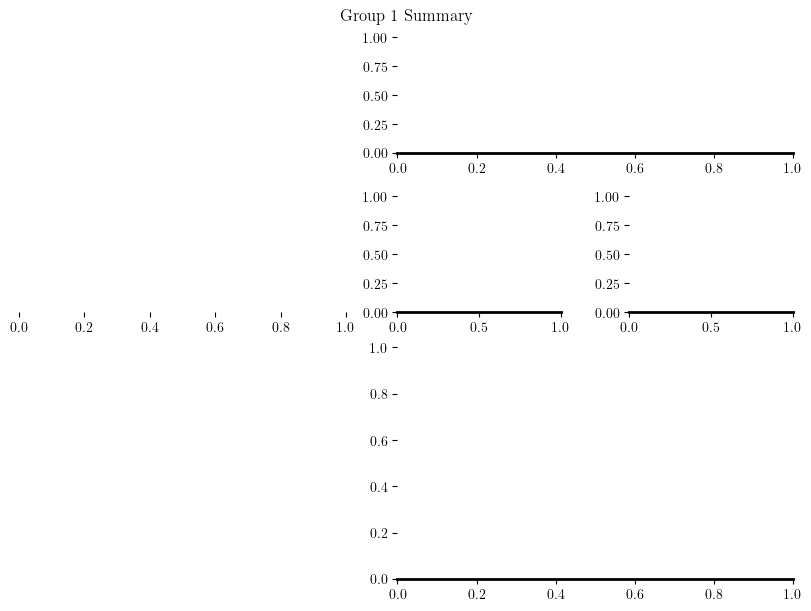

In [184]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)

gs = fig.add_gridspec(ncols=3,nrows=3,width_ratios=[2,1,1],height_ratios=[1,1,2])

waveform_ax = fig.add_subplot(gs[:2,0])
waveform_ax.spines['top'].set_visible(False)
waveform_ax.spines['bottom'].set_visible(False)
waveform_ax.spines['left'].set_visible(False)
waveform_ax.spines['right'].set_visible(False)
waveform_ax.set_yticks([])


rose_ax = fig.add_subplot(gs[2,0],projection='polar')

rose_ax.set_theta_zero_location('N',offset=-long)
rose_ax.set_xticks([])
rose_ax.set_yticks([])
rose_ax.spines['polar'].set_visible(False)

event_ax = fig.add_subplot(gs[0,1:])

event_ax.spines['top'].set_visible(False)
event_ax.spines['left'].set_visible(False)
event_ax.spines['right'].set_visible(False)

daily_ax = fig.add_subplot(gs[1,1])

daily_ax.spines['top'].set_visible(False)
daily_ax.spines['left'].set_visible(False)
daily_ax.spines['right'].set_visible(False)

tidal_ax = fig.add_subplot(gs[1,2])

tidal_ax.spines['top'].set_visible(False)
tidal_ax.spines['left'].set_visible(False)
tidal_ax.spines['right'].set_visible(False)

slow_ax = fig.add_subplot(gs[2,1:])

slow_ax.spines['top'].set_visible(False)
slow_ax.spines['left'].set_visible(False)
slow_ax.spines['right'].set_visible(False)

fig.suptitle('Group 1 Summary')

templates = {'1a':'20180108T014910Z',
             '1b':'20180108T000712Z',
             '1c':'20180108T012115Z',
             '1d':'20180108T003342Z'}

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

left = mcolors.to_rgb('white')
middle = mcolors.to_rgb('maroon')
right = mcolors.to_rgb('black')

custom_cm = LinearSegmentedColormap.from_list('custom',[left,middle,right])



xcorr_mat = np.zeros((len(templates),len(templates)))
shift_mat = np.zeros((len(templates),len(templates)))

for i, event_id_1 in enumerate(templates.values()):
    event_1 = bbs_event_cat.select_event(event_id_1)
    event_1.attach_waveforms(inv_bbs,w_path,buffer=2,length=4,extra=10)
    event_1.filter('highpass',freq=1)

    for j, event_id_2 in enumerate(templates.values()):
        event_2 = bbs_event_cat.select_event(event_id_2)
        event_2.attach_waveforms(inv_bbs,w_path,buffer=2,length=4,extra=10)
        event_2.filter('highpass',freq=1)

        shift, xc = ec.cross_correlate(event_1,event_2)
        xcorr_mat[i,j] = xc
        shift_mat[i,j] = shift

In [185]:
i = 0
for name, template in templates.items():
    event = bbs_event_cat.select_event(template)
    
    event.attach_waveforms(inv_bbs,w_path,buffer=2,length=4,extra=10)
    event.filter('highpass',freq=1)

    max_energy = 0.0
    for tr in event.get_data_window().select(component='Z'):
        energy = np.sum(tr.data**2)
        if energy > max_energy:
            max_energy = energy
            max_tr = tr
    
    net, sta, loc, ch = max_tr.id.split('.')
    max_tr2 = event.stream.select(network=net,station=sta,channel=ch)[0]

    if i > 0:
        shift += shift_mat[i,i-1] / 100
    else:
        shift = 0.0

        
    shift_window = [event.data_window[0] + shift, event.data_window[1] + shift]
    #tr = max_tr.trim(*shift_window,pad=True,fill_value=None)
    tr = max_tr2.trim(*shift_window,pad=True,fill_value=None)

    offset = 10*i

    waveform_ax.plot(tr.times(),tr.data/np.abs(tr.data).max()*4 + offset,lw=0.8,color=custom_cm((i+1)/5))

    i += 1

In [186]:
beamform = pd.read_csv(os.path.join(c_path,'beamforming.csv'),index_col=0)
beamform['baz'] = beamform['baz'] * np.pi / 180

In [187]:
chunk = do.SeismicChunk(t1,t2,time_offset=7)


"""BINNING PARAMETERS"""
daily_bins = 60*60 #10 minute bins for diurnal cycles
total_bins = 1*60*60 #hour long bins for entire season
tide_bins = 20 #width in degrees of bins


"""BIN CONSTRUCTION"""
total_bin_edges = np.mgrid[chunk.starttime:chunk.endtime:total_bins]
total_bin_centres = total_bin_edges + total_bins / 2
total_bin_edges_mt = np.array([time.matplotlib_date for time in total_bin_edges])

day_start = UTCDateTime(2018,1,1)
day_end = UTCDateTime(2018,1,2)

daily_bin_edges = np.mgrid[day_start:day_end:daily_bins]
daily_bin_centres = daily_bin_edges + daily_bins / 2
daily_bin_edges_mt = np.array([time.matplotlib_date for time in daily_bin_edges])

tide_bin_edges = np.mgrid[-180:180:tide_bins]
tide_bin_centres = tide_bin_edges + tide_bins / 2

"""ENVIRONMENTAL DATA"""
chunk.context('timeseries')
chunk.attach_environmental(env_path)
temp = chunk.env_stream.select(channel='TEM')[0]
tide = chunk.env_stream.select(channel='TID')[0]
phase = chunk.env_stream.select(channel='PHA')[0]


#GET EVENT TIMES IN REQUIRED FORMAT FOR BINNING (TIME OF YEAR, TIME OF DAY, TIDAL PHASE)

groups = [str(i) for i in range(1,9)]

total_binned = {}
daily_binned = {}
tidal_binned = {}

for temp_name, temp_id in templates.items():
    group_cat = bbs_event_cat.events[bbs_event_cat.events['event_id'].isin(xcorr[xcorr['template']==temp_name]['event_id'])]
    group_times = group_cat['ref_time'].to_numpy()
    group_times = np.array([UTCDateTime(time) for time in group_times],dtype=UTCDateTime)

    event_times_mt = [time.matplotlib_date for time in group_times]
    daily_event_times_mt = [UTCDateTime(2018,1,1,time.hour,time.minute,time.second).matplotlib_date for time in group_times]
    dt = (group_times - tide.stats.starttime).astype(np.float64)
    event_phase = np.interp(dt,phase.times(),phase.data)

    total_binned[temp_name] = np.bincount(np.digitize(event_times_mt,total_bin_edges_mt)-1,minlength=total_bin_edges_mt.size)

    daily_binned[temp_name] = np.bincount(np.digitize(daily_event_times_mt,daily_bin_edges_mt)-1,minlength=daily_bin_edges_mt.size)
    
    tidal_binned[temp_name] = np.bincount(np.digitize(event_phase,tide_bin_edges)-1,minlength=tide_bin_edges.size)

In [188]:
t_mt = [time.matplotlib_date for time in total_bin_centres]
day_mt = [time.matplotlib_date for time in daily_bin_centres]

total_cumulative = np.zeros_like(total_binned['1a'])
daily_cumulative = np.zeros_like(daily_binned['1a'])
tidal_cumulative = np.zeros_like(tidal_binned['1a'])


for i, group in enumerate(templates):
    event_ax.bar(t_mt,height=total_binned[group],width=t_mt[1]-t_mt[0],bottom=total_cumulative,align='center',color=custom_cm((i+1)/5))
    total_cumulative += total_binned[group]

    daily_ax.bar(day_mt,height=daily_binned[group],width=day_mt[1] - day_mt[0],bottom=daily_cumulative,align='center',color=custom_cm((i+1)/5))
    daily_cumulative += daily_binned[group]

    tidal_ax.bar(tide_bin_centres,height=tidal_binned[group],width=tide_bin_centres[1]-tide_bin_centres[0],bottom=tidal_cumulative,align='center',color=custom_cm((i+1)/5))
    tidal_cumulative += tidal_binned[group]

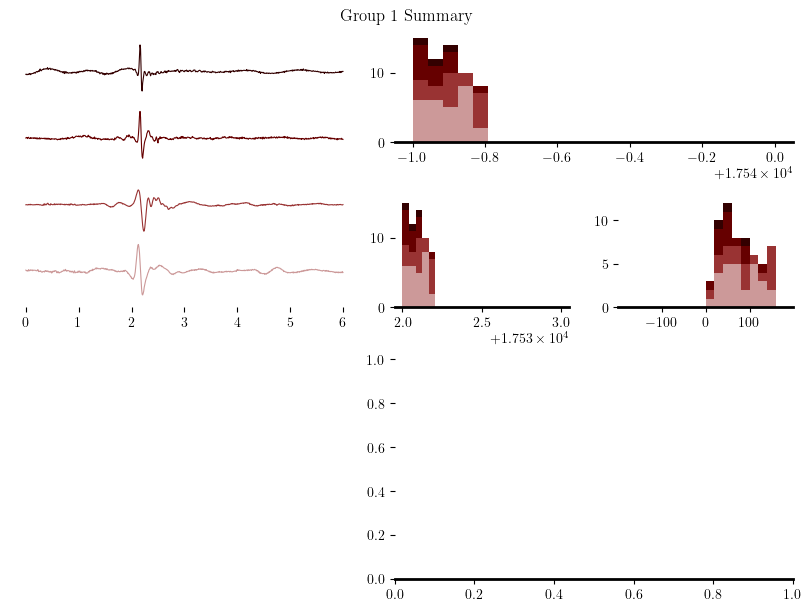

In [189]:
fig

In [190]:
num_bins = 8
slow_bins = 20

bin_edges = np.linspace(0,2*np.pi,num_bins+1)
width = bin_edges[1] - bin_edges[0]

slow_edges = np.linspace(0,1,slow_bins+1)
slow_width = slow_edges[1] - slow_edges[0]
slow_ind = np.arange(slow_bins)

bin_ind = np.arange(num_bins)
beamform['baz_bin'] = pd.cut(beamform['baz'],bin_edges,labels=bin_ind) #bin the attribute as a new column in the dataframe
beamform['slow_bin'] = pd.cut(beamform['slow'],slow_edges,labels=slow_ind)


cumulative = np.zeros_like(bin_ind)
slow_cumulative = np.zeros_like(slow_ind)
i = 0
c = ['maroon','red','darkorange','hotpink','gold','purple','blue','darkgreen']


for i, temp_name in enumerate(templates):
    group_beamform = beamform[beamform.index.isin(xcorr[xcorr['template']==temp_name]['event_id'])]

    counts = group_beamform['baz_bin'].value_counts().to_dict()
    slow_count = group_beamform['slow_bin'].value_counts().to_dict()

    for key in bin_ind:
        counts.setdefault(key,0)
    
    for key in slow_ind:
        slow_count.setdefault(key,0)

    values = np.array([counts[i] for i in range(len(bin_ind))])
    slow_values = np.array([slow_count[i] for i in range(len(slow_ind))])
    rose_ax.bar(bin_edges[:-1],values,width=width,bottom=cumulative,align='edge',color=custom_cm((i+1)/5))
    slow_ax.bar(slow_edges[:-1],slow_values,width=slow_width,bottom=slow_cumulative,align='edge',color=custom_cm((i+1)/5))

    cumulative += values
    slow_cumulative += slow_values

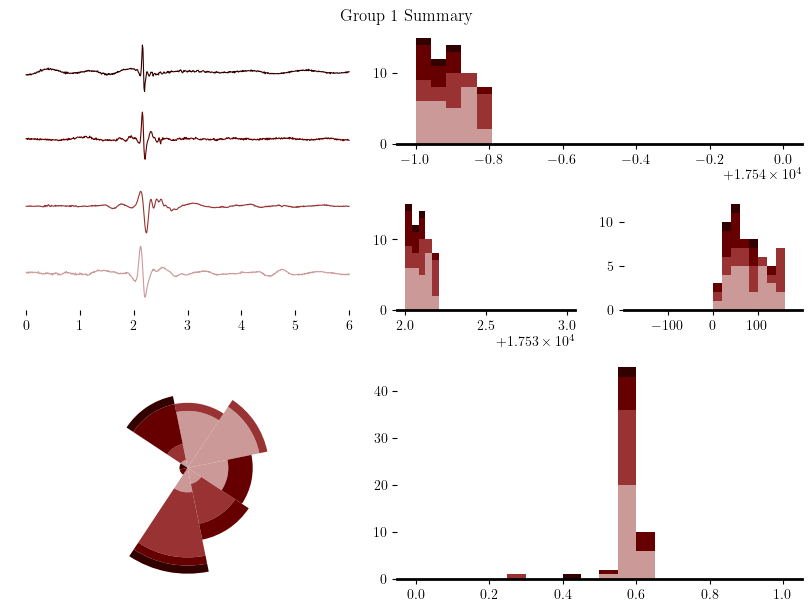

In [191]:
fig

In [155]:
chunk = do.SeismicChunk(t1,t2,time_offset=7)


"""BINNING PARAMETERS"""
daily_bins = 10*60 #10 minute bins for diurnal cycles
total_bins = 1*60*60 #hour long bins for entire season
tide_bins = 2.5 #width in degrees of bins
att_bin_num = 40 #number of bins to place attributes in


"""BIN CONSTRUCTION"""
total_bin_edges = np.mgrid[chunk.starttime:chunk.endtime:total_bins]
total_bin_centres = total_bin_edges + total_bins / 2
total_bin_edges_mt = np.array([time.matplotlib_date for time in total_bin_edges])

day_start = UTCDateTime(2018,1,1)
day_end = UTCDateTime(2018,1,2)

daily_bin_edges = np.mgrid[day_start:day_end:daily_bins]
daily_bin_centres = daily_bin_edges + daily_bins / 2
daily_bin_edges_mt = np.array([time.matplotlib_date for time in daily_bin_edges])

tide_bin_edges = np.mgrid[-180:180:tide_bins]
tide_bin_centres = tide_bin_edges + tide_bins / 2

"""ENVIRONMENTAL DATA"""
chunk.context('timeseries')
chunk.attach_environmental(env_path)
temp = chunk.env_stream.select(channel='TEM')[0]
tide = chunk.env_stream.select(channel='TID')[0]
phase = chunk.env_stream.select(channel='PHA')[0]


#GET EVENT TIMES IN REQUIRED FORMAT FOR BINNING (TIME OF YEAR, TIME OF DAY, TIDAL PHASE)

groups = [str(i) for i in range(1,9)]

total_binned = {}
daily_binned = {}
tidal_binned = {}

for group in groups:
    group_cat = bbs_event_cat.events[bbs_event_cat.events['event_id'].isin(xcorr[xcorr['group']==group].index)]
    group_times = group_cat['ref_time'].to_numpy()
    group_times = np.array([UTCDateTime(time) for time in group_times],dtype=UTCDateTime)

    event_times_mt = [time.matplotlib_date for time in group_times]
    daily_event_times_mt = [UTCDateTime(2018,1,1,time.hour,time.minute,time.second).matplotlib_date for time in group_times]
    dt = (group_times - tide.stats.starttime).astype(np.float64)
    event_phase = np.interp(dt,phase.times(),phase.data)

    total_binned[group] = np.bincount(np.digitize(event_times_mt,total_bin_edges_mt)-1,minlength=total_bin_edges_mt.size)

    daily_binned[group] = np.bincount(np.digitize(daily_event_times_mt,daily_bin_edges_mt)-1,minlength=daily_bin_edges_mt.size)
    
    tidal_binned[group] = np.bincount(np.digitize(event_phase,tide_bin_edges)-1,minlength=tide_bin_edges.size)




In [193]:
xcorr['template'].unique()

array(['1a', '0', '3a', '1c', '3b', '1b', '2a', '3c', '7a', '4a', '4b',
       '7b', '1d', '2b', '8a', '7c', '2c', '5a', '6a', '8b', '6b', '5b',
       '8c'], dtype=object)

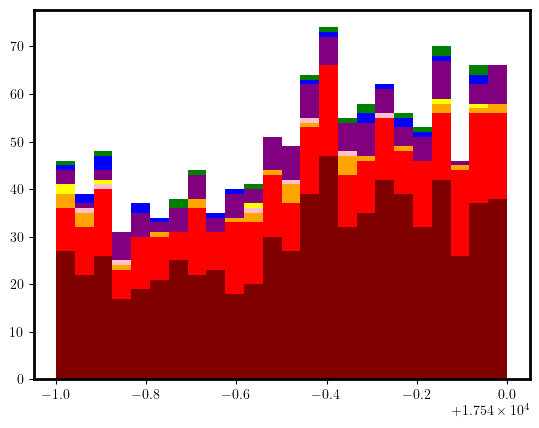

In [43]:
fig = plt.figure()
hist_ax = fig.add_subplot(111)

t_mt = [time.matplotlib_date for time in total_bin_centres]

cumulative = np.zeros_like(total_binned['1'])
colors = ['maroon','red','orange','pink','yellow','purple','blue','green']

for i, group in enumerate(groups):
    hist_ax.bar(t_mt,height=total_binned[group],width=t_mt[1]-t_mt[0],bottom=cumulative,align='center',color=colors[i])
    cumulative += total_binned[group]


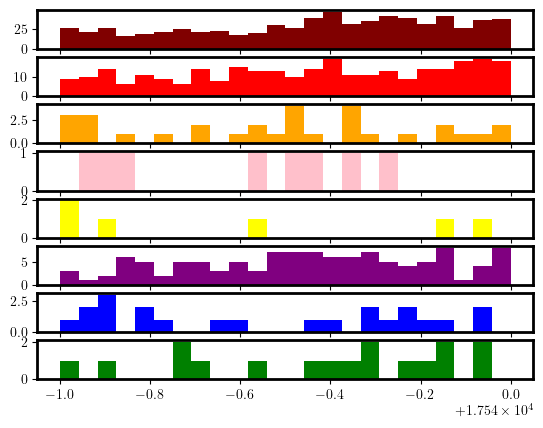

In [44]:
fig, hist_ax = plt.subplots(nrows=8)
for i, group in enumerate(groups):
    hist_ax[i].bar(t_mt,height=total_binned[group],width=t_mt[1]-t_mt[0],bottom=0,align='center',color=colors[i])
    cumulative += total_binned[group]

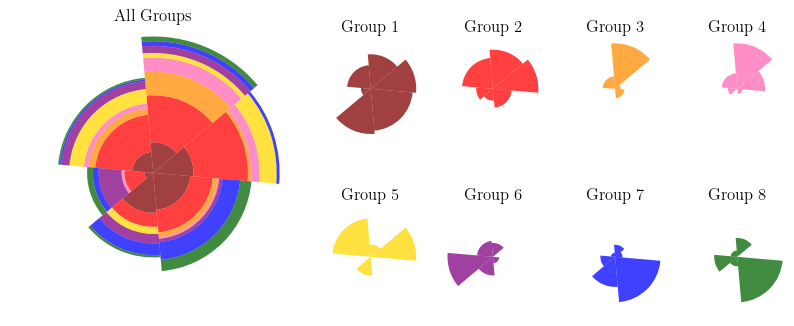

In [30]:
offset = 5 #first sector is 5 degrees off north
angles = [80,45,55,80,45,55] #opening angle of each sector

right = []
for angle in angles:
    right.append(offset)
    offset += angle

#now convert everything to radians
angles = np.deg2rad(np.array(angles))
right = np.deg2rad(np.array(right))


fig = plt.figure(figsize=(10,4))
grid_spec = fig.add_gridspec(ncols=5,nrows=2,width_ratios=[3,1,1,1,1])
comb_ax = fig.add_subplot(grid_spec[:,0],projection='polar')
comb_ax.set_theta_zero_location('N')
comb_ax.set_xticks([])
comb_ax.set_yticks([])
comb_ax.spines['polar'].set_visible(False)
comb_ax.set_title('All Groups')

cumulative = np.zeros(6)
i = 0
c = ['maroon','red','darkorange','hotpink','gold','purple','blue','darkgreen']
for group in range(1,9):
    group_cat = class_cat[class_cat['group']==group]
    counts = group_cat['arrival'].value_counts().to_dict()
    for key in ['965','956','596','569','659','695']:
        counts.setdefault(key,0)
    values = np.array([counts['965'],counts['956'],counts['596'],counts['569'],counts['659'],counts['695']])
    
    values = values.astype(np.float64)
    values /= angles
    comb_ax.bar(right,values,width=angles,bottom=cumulative,align='edge',color=c[i],alpha=0.75)
    
    cumulative += values
    
    sing_ax = fig.add_subplot(grid_spec[i//4,i%4 + 1],projection='polar')
    sing_ax.set_theta_zero_location('N')
    sing_ax.set_xticks([])
    sing_ax.set_yticks([])
    sing_ax.spines['polar'].set_visible(False)
    sing_ax.bar(right,values,width=angles,align='edge',color=c[i],alpha=0.75)
    sing_ax.set_title('Group ' + str(group))
    
    i += 1

fig.savefig(os.path.join(plot_path,'rose_plot.pdf'),format='pdf')

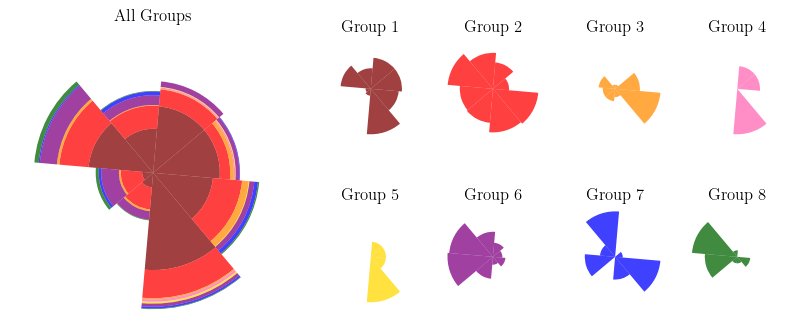

In [61]:
num_bins = 8
bin_edges = np.linspace(0,2*np.pi,num_bins+1)
width = bin_edges[1] - bin_edges[0]

bin_ind = np.arange(num_bins)
beamform['bin'] = pd.cut(beamform['baz'],bin_edges,labels=bin_ind) #bin the attribute as a new column in the dataframe

fig = plt.figure(figsize=(10,4))
grid_spec = fig.add_gridspec(ncols=5,nrows=2,width_ratios=[3,1,1,1,1])
comb_ax = fig.add_subplot(grid_spec[:,0],projection='polar')
comb_ax.set_theta_zero_location('N',offset=-long)
comb_ax.set_theta_direction(-1)
comb_ax.set_xticks([])
comb_ax.set_yticks([])
comb_ax.spines['polar'].set_visible(False)
comb_ax.set_title('All Groups')

cumulative = np.zeros_like(bin_ind)
i = 0
c = ['maroon','red','darkorange','hotpink','gold','purple','blue','darkgreen']

for group in groups:
    group_beamform = beamform[beamform.index.isin(xcorr[xcorr['group']==group].index)]

    counts = group_beamform['bin'].value_counts().to_dict()
    for key in bin_ind:
        counts.setdefault(key,0)
    
    values = np.array([counts[i] for i in range(len(bin_ind))])
    comb_ax.bar(bin_edges[:-1],values,width=width,bottom=cumulative,align='edge',color=c[i],alpha=0.75)

    cumulative += values

    sing_ax = fig.add_subplot(grid_spec[i//4,i%4 + 1],projection='polar')
    sing_ax.set_theta_zero_location('N',offset=-long)
    sing_ax.set_theta_direction(-1)
    sing_ax.set_xticks([])
    sing_ax.set_yticks([])
    sing_ax.spines['polar'].set_visible(False)
    sing_ax.set_title('Group ' + str(group))

    sing_ax.bar(bin_edges[:-1],values,width=width,align='edge',color=c[i],alpha=0.75)
    
    i += 1